# Final Project

### Names: Nathan Ofir - 210355080, Filip Slepcev - 212314500, Ajay Sodhi - 200755340




## Introduction
Housing is a fundamental component of well-being and financial stability. In Canada, a country known for its vast landscapes and diverse cities, the rental market is a critical indicator of the socio-economic status and the living standards of its residents. This report delves into the Canada's rental market from 1987 to 2022, offering a visual narrative of how rental prices have evolved over the past thirty-five years.

Leveraging a comprehensive dataset provided by the Government of Canada, we mapped out the average rental costs for a variety of housing unit types across Canadian cities. By evaluating average rental costs, we not only uncover changes in pricing but also shed light on the broader trends affecting the Canada's housing market.

## Our Motivation Behind the Analysis
The motivation behind this analysis stems from being canadian students and potential canadian renters who will have to participate in the rental market for the foreseeable future. Understanding the long-term trends and potential forecasts of rental prices is not only an academic exercise but a subject that impacts the aspects of our lives. This analysis will provides us with insights that can guide our current and future choices in the rental market.

## Propose Approach
### Our question: 
How have rents changed accross Canada from 1987 to 2022.

### Data set description: 
The data set is labeled as "Average rents for areas with a population of 10,000 and over - Dataset", and contains information under the following headers: REF_DATE (the year), GEO (Entered as City, Province), DGUID (An ID number unique to this location), Type of structure (either Row structures and apartments, apartments, or Row structures), the Type of unit (Bedroom count),UOM (the unit of measurement), UOM_ID, SCALAR_FACTOR, SCALAR_ID, VECOTR, COORDINATE, VALUE (The rental price), status (the reliability of the data), SYMBOL, TERMINATED, DECIMALS. This report was mainly focused on the information found in GEO, Type of unit, and VALUE.

### Data processing: 
Data was processed by importing the dataset csv as a Pandas dataframe. The dataframe was refined to remove entries without rental prices by using the labels present in the dataset that were represented as "F" data was unreliable, or "..." data was unavailable. This was further refined to specifically identify One bedroom units as this was the majority of the focus of our report. The dataframe then had a new column added that was based on parsing the "GEO" colum for the city name to identify the specific city and to provide an overall easier to read visualization.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import numpy as np



C:\Users\natha\AppData\Local\Temp\ipykernel_29328\1745148331.py:42: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


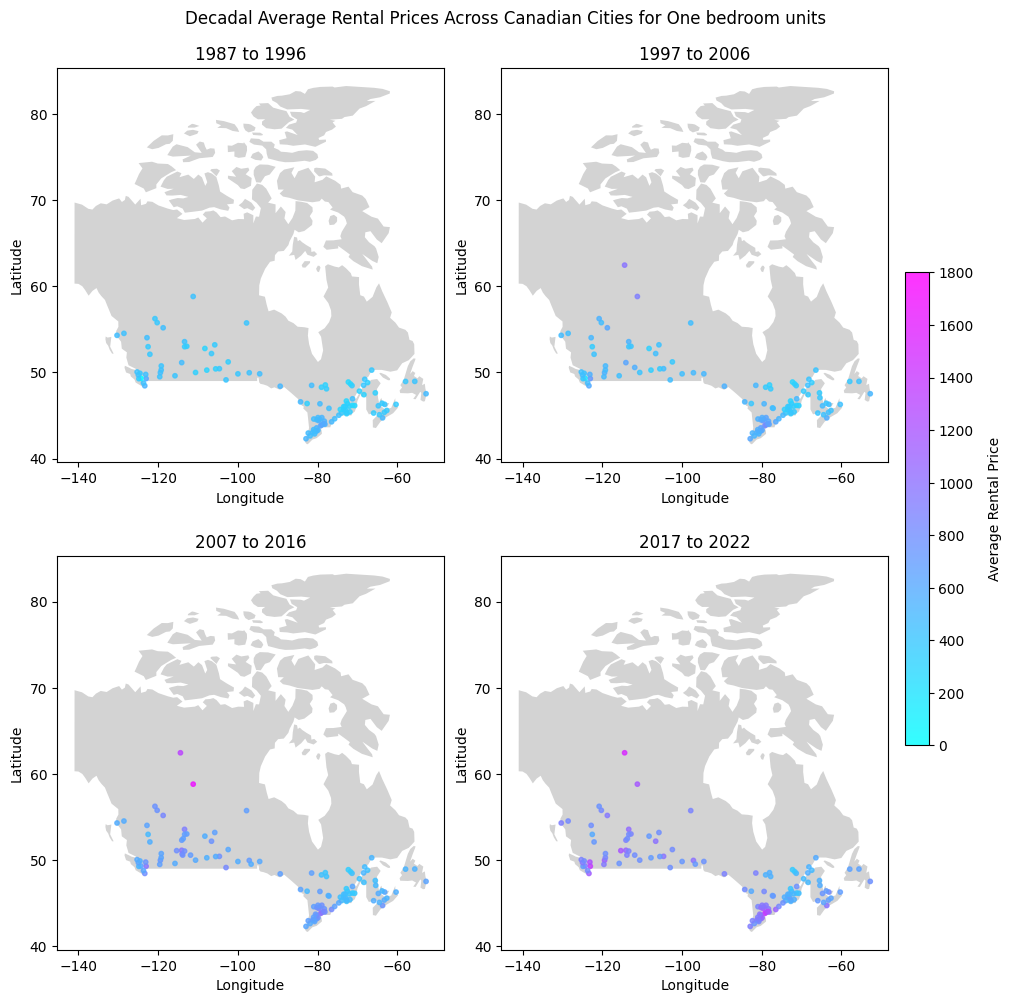

In [81]:
# Constants
rental_type="One bedroom units"
encoding='ISO-8859-1'

# Define the path for the CSVs
filtered_geo_csv = 'data/filtered_geographic_attributes.csv'
geo_csv = 'data/geographic_attributes.csv'
rentals_csv = 'data/34100133.csv'

# Load the rental prices data
rental_prices = pd.read_csv(rentals_csv, low_memory=False)

# Filter and clean the rental prices data
rents = rental_prices.query(f'STATUS != "F" and STATUS != ".." and `Type of unit` == "{rental_type}"').copy()
rents.loc[:, 'CITY'] = rents['GEO'].apply(lambda row: row.split(",")[0])
rents.loc[:, 'DGUID'] = rents['DGUID'].str[4:]  # Remove the first four characters

# Load the Geographic Attribute File with selected columns and specified encoding
columns_to_keep = ['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM', 'DARPLAT_ADLAT', 'DARPLONG_ADLONG']



geo_attributes = pd.read_csv(geo_csv, encoding = encoding,usecols=columns_to_keep, low_memory=False)
geo_attributes['CMADGUID_RMRIDUGD'] = geo_attributes['CMADGUID_RMRIDUGD'].str[4:]  # Remove the first four characters

# Remove duplicates based on the 'CMADGUID_RMRIDUGD' and 'CSDNAME_SDRNOM' columns
geo_attributes = geo_attributes.drop_duplicates(subset=['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM'])

# Save the filtered Geographic Attribute File to a new CSV file
geo_attributes.to_csv(filtered_geo_csv, index=False)



# Merge the rental prices data with the filtered Geographic Attribute File
# Ensure that both the DGUID and city name match
merged_data = pd.merge(rents, geo_attributes, left_on=['DGUID', 'CITY'], right_on=['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM'], how='left')

# Filter out rows with missing coordinates
merged_data.dropna(subset=['DARPLAT_ADLAT', 'DARPLONG_ADLONG'], inplace=True)

# Load world map and filter for Canada
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
canada = world.query("name == 'Canada'")

# Determine 50-year intervals
min_year = min(rents["REF_DATE"])
max_year = max(rents["REF_DATE"])

num_decades = (max_year - min_year) // 10 + 1
rows = int(np.ceil(num_decades / 2))
cols = 2 if num_decades > 1 else 1

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows), constrained_layout=True)
axes = axes.flatten()

# Index for current subplot in the loop
ax_idx = 0

for start_year in range(min_year, max_year + 1, 10):
    end_year = start_year + 9 if (start_year + 9) <= max_year else max_year
    # Filter data for the current decade
    decade_data = merged_data[(merged_data['REF_DATE'] >= start_year) & (merged_data['REF_DATE'] <= end_year)]

    if not decade_data.empty:
        # Calculate average rental prices for each location within the decade
        avg_decade_data = decade_data.groupby(['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM']).agg({
            'VALUE': 'mean',
            'DARPLAT_ADLAT': 'first',    
            'DARPLONG_ADLONG': 'first'   
        }).reset_index()

        # Plot in the current subplot
        ax = axes[ax_idx]
        canada.plot(color='lightgrey', ax=ax)
        scatter = ax.scatter(x=avg_decade_data['DARPLONG_ADLONG'], y=avg_decade_data['DARPLAT_ADLAT'],
                             c=avg_decade_data['VALUE'], cmap='cool', s=10, alpha=0.8, vmin=0, vmax=1800)
        ax.set_title(f'{start_year} to {end_year}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        ax_idx += 1

# Colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', pad=0.02, aspect=20, shrink=0.5)
cbar.set_label('Average Rental Price', rotation=90, labelpad=10)

# Add a main title to the figure
fig.suptitle(f'Decadal Average Rental Prices Across Canadian Cities for {rental_type}', fontsize=12)
plt.show()

The four images above offer a visual representation of rental prices across different regions in Canada, captured at distinct time intervals from 1987 to 2022. Each map pinpoints the fluctuating costs of rentals, illustrating not only how prices have varied geographically but also highlighting areas that have experienced significant changes over the decades. These visualizations serve as a tool for identifying regions with rising or declining rental markets and help in understanding the spatial distribution of housing affordability across the country. By observing these patterns, we can understand the economic landscape of  Canadian cities and the effects on residents searching for rental accommodations.

Text(0.5, 0, 'City Names')

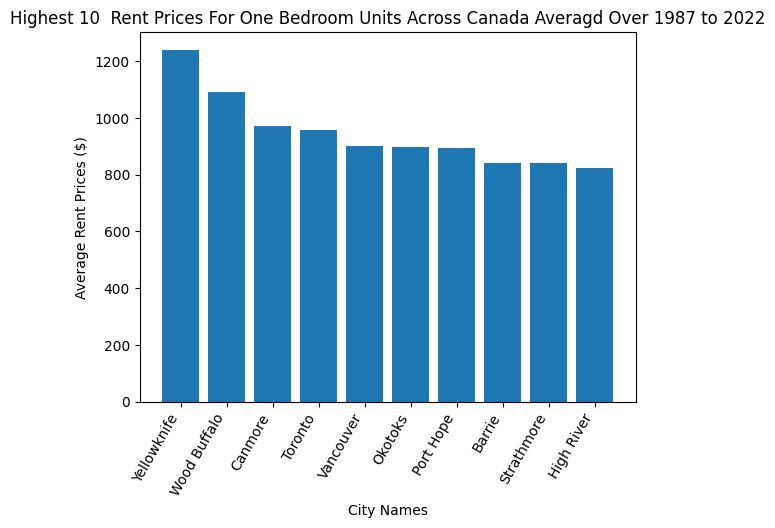

In [82]:
"""
Extracts city from location data
"""
def cityname(row):
   return row['GEO'].split(",")[0]
rents = pd.read_csv('data/34100133.csv',sep=',',low_memory=False).query("STATUS != 'F' and STATUS != '..' and `Type of unit` == 'One bedroom units'")
rents['CITY'] = rents.apply(cityname, axis=1)#creates new column with parsed citynames
citynames = []
"""
Fills citynames with a single element for each city
"""
def cities(row):
    global citynames
    if row['CITY'] not in citynames:
        citynames.append(row['CITY'])
rents.apply(cities, axis=1)
avgs = []#[cityname, average rents for each city]
for i in citynames:
    avgs.append([i, np.mean(rents.query("CITY == @i")['VALUE'].to_numpy())])
avgs2 = sorted(avgs, key=lambda x: x[1], reverse = True)[:10]#Sorts by rental price, and retrieves highest 10 entries
cities, rentprices = map(list, zip(*avgs2))#splits list into 2 separate lists representing the city name, and the rent prices
fig, axes = plt.subplots()
plt.bar(cities,rentprices)
for tick in axes.get_xticklabels():
    tick.set_horizontalalignment("right")
    tick.set_rotation(60)
axes.set_title(f"Highest 10  Rent Prices For One Bedroom Units Across Canada Averagd Over {min(rents['REF_DATE'])} to {max(rents['REF_DATE'])}")
axes.set_ylabel("Average Rent Prices ($)")
axes.set_xlabel("City Names")

The highest average rental price accross canada brelongs to Yellowknife, followed closely by Wood Buffalo, Canmore, Toronto and Vancouver. Overall, the top 10 are relatively consistent in price after the top 2. 

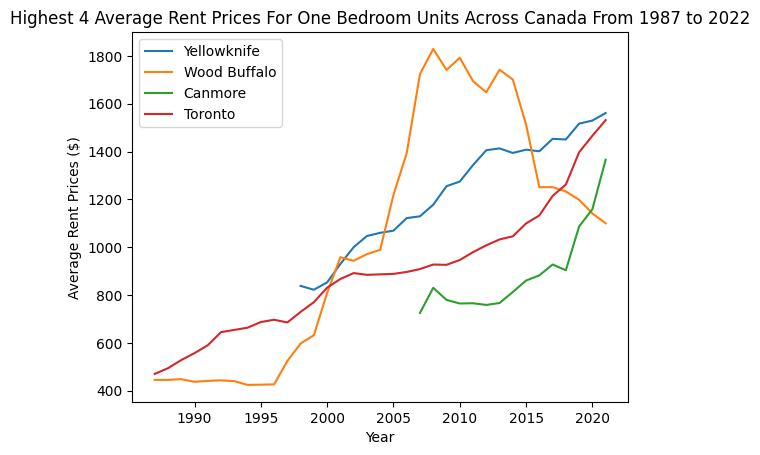

In [83]:
fig, axes = plt.subplots()
highest = cities[:4]
highest.sort
for i in highest:
    dates_raw = rents.query("CITY == @i")['REF_DATE'].to_numpy()
    values_raw = rents.query("CITY == @i")['VALUE'].to_numpy()
    dates = []
    values = []
    for j in range(min(rents['REF_DATE']),max(rents['REF_DATE'])):
        tbaveraged = []
        while len(dates_raw) > 0 and dates_raw[0] == j:
            x,values_raw = values_raw[0],values_raw[1:]
            tbaveraged.append(x)
            dates_raw = dates_raw[1:]
        dates.append(j)
        if len(tbaveraged) > 0:
            values.append(np.mean(tbaveraged))
        else:
            values.append(None)
    plt.plot(dates,values,label =i)
axes.set_title(f"Highest 4 Average Rent Prices For One Bedroom Units Across Canada From {min(rents['REF_DATE'])} to {max(rents['REF_DATE'])}")
axes.set_ylabel("Average Rent Prices ($)")
axes.set_xlabel("Year")
plt.legend()

Over time it can be seen that rents are always trending upwards. However, There are noticeable time periods in which rents spike and others drop. Wood Buffalo sees several large spikes, from 1996-2003 as well as 2005-2010, and a sharp drop from 2013-2015, and will likely require further investigation int oboth the availability of property, as well as the finances of people living there to specifically see what caused these spikes.

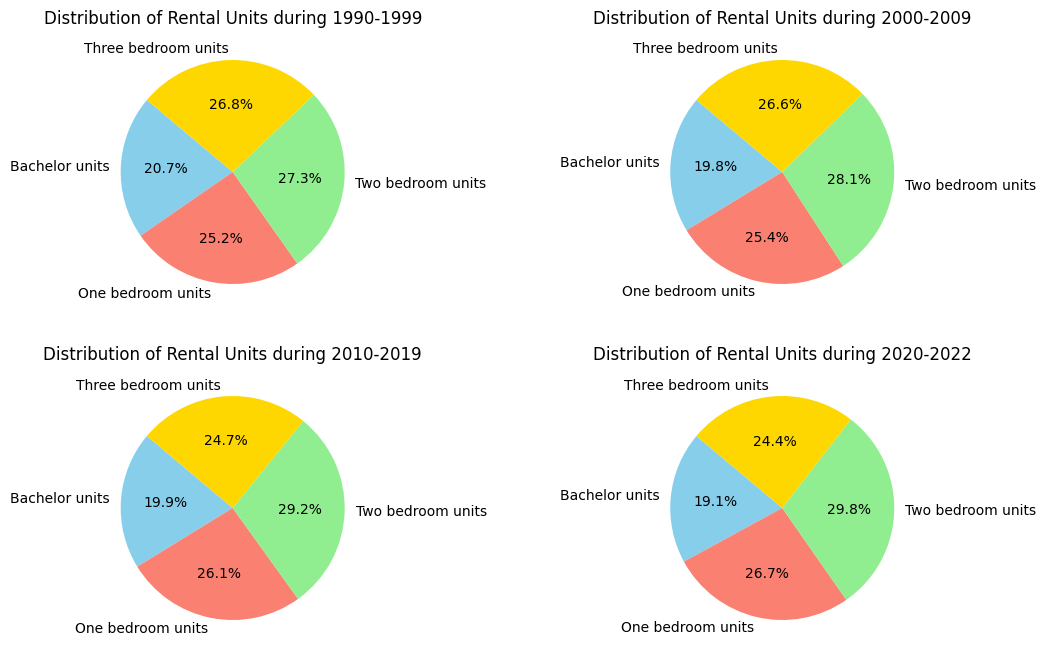

In [84]:
rents.head(50)
rents = pd.read_csv('data/34100133.csv',sep=',',low_memory=False).query("STATUS != 'F' and STATUS != '..'")
decades = {
    '1990-1999': (1990, 1999),
    '2000-2009' : (2000, 2009),
    '2010-2019' : (2010, 2019),
    '2020-2022' : (2020, 2022)
}

colors= {
    'Bachelor units' : 'skyblue',
    'One bedroom units' : 'salmon',
    'Two bedroom units' : 'lightgreen',
    'Three bedroom units' : 'gold'
}


all_unit_types = ['Bachelor units', 'One bedroom units', 'Two bedroom units', 'Three bedroom units']
fig, [[ax1,ax2],[ax3,ax4]]= plt.subplots(2,2,figsize=(13, 8))
axs = [ax1,ax2,ax3,ax4]
i = 0
for name, (start_year, end_year) in decades.items():
    
    decade_data = rents[(rents['REF_DATE'] >= start_year) & (rents['REF_DATE'] <= end_year)]

    count_units = decade_data['Type of unit'].value_counts()
    
    for unit_type in all_unit_types:
        if unit_type not in count_units:
            count_units[unit_type] = 0

    count_units = count_units.reindex(all_unit_types, fill_value=0)

    segment_colors = [colors[unit] for unit in count_units.index if unit in colors]

    
    axs[i].pie(count_units, labels=count_units.index, autopct='%1.1f%%', colors=segment_colors, startangle=140)
    axs[i].set_title(f'Distribution of Rental Units during {name}')
    i+=1
plt.show()

These visualizations display the distribution of rental unit types across different time periods in Canada. A slight shift is noticeable over time, two bedroom and one bedroom units make up more of the total distribition while bachelor and three bedroom units make up less of it. These visualizations provide insight into how the composition of the rental market changes over time which is significant because it influences other areas of the rental market. For example, the preference displayed over time for one bedroom and two bedroom units may help us better understand rent prices today.

## Conclusion
This comprehensive analysis of Canada's rental market from 1987 to 2022 has provided valuable insight into the dynamics of housing costs, revealing key trends and implications for renters across Canada. These visualizations equip future renters and Canadian students with the necessary information to make informed decisions by examining how rental prices of one-bedroom units have changed over time across Canada and identifying trends in the overall distribution of rental units. It is imperative to understand these trends and patterns as the rental market evolves to make effective decisions while planning and creating policies aimed at improving economic conditions for residents across Canada.

## Citations

1. Average Rents for Areas with a Population of 10,000 and over - Dataset. 1 Dec. 2016, https://open.canada.ca/data/en/dataset/1146388b-a150-4e70-98ec-eb40cb9083c8/resource/2be23210-9dd2-4511-840e-c467e0645827#additional-info.

2. Government of Canada, Statistics Canada. “2021 Census.” Geographic Attribute File, 10 Feb. 2022, <a href="https://www12.statcan.gc.ca/census-recensement/2021/geo/aip-pia/attribute-attribs/index2021-eng.cfm?year=2021">www12.statcan.gc.ca/census-recensement/2021/geo/aip-pia/attribute-attribs/index2021-eng.cfm?year=2021.</a>
 